# Writing useful files

In [1]:
%%writefile utils_attack.py
from tqdm import tqdm
import numpy as np
import pandas as pd
from functools import partial

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

from typing import (
    List, Tuple, Dict, Any,
    Optional, Sequence, Callable
)

def calculate_acc(
    target: np.ndarray, y_pred: np.ndarray
) -> float:
    """Calculate Accuracy.

    :param target: array with true labels
    :param y_pred: array with predictions
    :return: accuracy
    """
    acc = (target == y_pred).mean()
    return acc

def req_grad(model: nn.Module, state: bool = True) -> None:
    """Set requires_grad of all model parameters to the desired value.

    :param model: the model
    :param state: desired value for requires_grad
    """
    for param in model.parameters():
        param.requires_grad_(state)

def get_image_grad_on_bacth(
    model: nn.Module,
    images: torch.tensor,
    labels: torch.tensor,
    loss: nn.Module
) -> torch.tensor:
    """Calculate gradient of loss w.r.t to images. It's supposed that
    images, labels and model are on the same device
    :param model: model that will be evaluated
    :param images: batch of images
    :param labels: batch of labels, corresponding to images
    :param loss: loss function
    :return: gradients of loss w.r.t to images
    """
    x_adv = torch.clone(images)
    x_adv.requires_grad = True

    logits = model(x_adv)
    loss_val = loss(logits, labels)
    loss_val.backward()
    
    return x_adv.grad.data

def attack_step(
    model,
    images,
    images_grad_sign,
    image_diap,
    eps
):
    """One step of gradient attack.
    :param model: model that will be evaluated
    :param images: batch of images
    :param images_grad: batch of gradients of loss w.r.t to images
    :param image_diap: min and max values of the images in loader, used for clipping
    :param eps: attack power
    :return: predictions of model under attack
    """
    attacked_images = images + eps * images_grad_sign
    attacked_images = attacked_images.clamp(*image_diap)
    logits_adv = model(attacked_images)
    _, preds_adv = torch.max(logits_adv, dim=1)
    
    return preds_adv

def get_adversarial_radii(
    model,
    len_of_batch,
    images,
    image_diap,
    preds_unattacked,
    images_grad_sign,
    max_steps,
    step_size,
    tol,
    device
):
    
    guess_left = torch.zeros(len_of_batch).to(device)
    guess_right = (torch.ones(len_of_batch)*step_size + tol*np.random.rand()).to(device)
    adversarial_radii_ = (torch.ones(len_of_batch) * np.inf).to(device)
    tolerances_ = (torch.ones(len_of_batch) * np.inf).to(device)
    step = 0

    while True and (step <= max_steps):
        guess_right = guess_right[:, None, None, None]
        preds_adv = attack_step(model, images, images_grad_sign, image_diap, guess_right)
        classified_correctly = (preds_unattacked == preds_adv.detach())
        guess_right = guess_right.squeeze()
        tolerances_[~classified_correctly] = (guess_right[~classified_correctly] - guess_left[~classified_correctly]) / 2.0
        adversarial_radii_[~classified_correctly] = guess_left[~classified_correctly] + tolerances_[~classified_correctly]
        
        if torch.all(tolerances_ <= tol):
            break
        
        if step != max_steps:
            buffer = guess_right[classified_correctly]
            guess_right[classified_correctly] = 2 * guess_right[classified_correctly] - guess_left[classified_correctly]
            guess_left[classified_correctly] = buffer
            guess_right[~classified_correctly] = (guess_right[~classified_correctly] + guess_left[~classified_correctly]) / 2.0            
        step += 1

    return adversarial_radii_, tolerances_

def fgsm_attack(
    model: nn.Module,
    loader: DataLoader,
    dataset_size: int,
    batch_size: int,
    image_diap: Tuple[float, float],
    loss: nn.Module,
    eps_list:  np.ndarray = None,
    mode: str = 'adversarial_radius',
    n_of_exp: int = 0,
    tol: float = 1e-4,
    step_size: float = 0.01,
    device: str = 'cpu'
):

    model.eval()
    req_grad(model, state=False)

    if mode == 'default':
        n_of_exp = len(eps_list)
    if mode == 'adversarial_radius':
        adversarial_radii = torch.tensor([], device=device)
        tolerances = torch.tensor([], device=device)
        
    targets = torch.tensor([], device=device)
    preds_attacked = torch.empty([n_of_exp, dataset_size], device=device)
    preds_unattacked = torch.tensor([], device=device)

    for idx, batch in tqdm(enumerate(loader), total=len(loader)):
        images, labels = batch[0].to(device), batch[1].to(device)
        len_of_batch = labels.size()[0]
        targets = torch.cat([targets, labels.detach()])
        logits = model(images)
        _, preds = torch.max(logits, dim=1)
        preds_unattacked = torch.cat([preds_unattacked, preds.detach()])

        # images_grad_sign = torch.sign(get_image_grad_on_bacth(model, images, preds, loss))
        images_grad_sign = get_image_grad_on_bacth(model, images, preds, loss)
        images_grad_sign = images_grad_sign / images_grad_sign.norm(dim=0)

        if mode == 'default':
            for i, eps in enumerate(eps_list):
                preds_adv = attack_step(model, images, images_grad_sign, image_diap, eps)
                preds_attacked[i, idx*batch_size:idx*batch_size+len_of_batch] = preds_adv.detach()

        elif mode == 'adversarial_radius':
            adversarial_radii_, tolerances_ = get_adversarial_radii(
                model,
                len_of_batch,
                images,
                image_diap,
                preds,
                images_grad_sign,
                max_steps=n_of_exp,
                step_size=step_size,
                tol=tol,
                device=device
            )
            adversarial_radii = torch.cat([adversarial_radii, adversarial_radii_])
            tolerances = torch.cat([tolerances, tolerances_])
            
    if mode == 'default':
        return (
            targets.cpu().numpy(),
            preds_attacked.cpu().numpy(),
            preds_unattacked.cpu().numpy(),
        )

    elif mode == 'adversarial_radius':
        return (
            targets.cpu().numpy(),
            adversarial_radii.cpu().numpy(),
            tolerances.cpu().numpy(),
            preds_unattacked.cpu().numpy()
        )

def sort_data_by_metric(
    metric: np.ndarray, preds: np.ndarray, labels: np.ndarray
) -> Tuple[List, List]:
    """Sort preds and labels by descending uncertainty metric.
    :param metric: uncertainty metric according to which preds and labels will be sorted 
                   (Expected logic: The more is uncertainty metric, the more is uncertainty)
    :param preds: model predictions
    :param labels: ground truth labels
    :return: a tuple of
        - np.ndarray of predictions, sorted according to metric
        - np.ndarray of labels, sorted according to metric
    """
    sorted_metric_idx = np.argsort(metric)
    return preds[sorted_metric_idx], labels[sorted_metric_idx]

def reject_by_metric(
    uncertainty_proxy: np.ndarray,
    preds: np.ndarray,
    labels: np.ndarray,
    rejection_rates: np.ndarray,
    scoring_func: Callable,
) -> List:
    """Reject points from preds and labels based on uncertainty estimate of choice.
    :param uncertainty_proxy: array of unceratinty estimations (e.g -adversarial radii)
    :param preds: model label predictions or predicted class probabilities
    :param labels: ground truth labels
    :param rejection_rates: list of rejection rates to use
    :param scoring_func: scoring function that takes labels and predictions or probabilities (in that order)
    :return: list of scores calculated for each rejection_rate
    """
    preds_sorted, labels_sorted = sort_data_by_metric(uncertainty_proxy, preds, labels)
    upper_bounds = len(preds) - np.ceil(rejection_rates * len(preds))
    
    scores = []
    for upper_bound in upper_bounds[:-1].astype('int'):
        scores.append(scoring_func(labels_sorted[:upper_bound], preds_sorted[:upper_bound]))
    
    return scores

Writing utils_attack.py


In [2]:
%%writefile utils_data.py
import os
import random
from tqdm import tqdm
import numpy as np
from sklearn.metrics import accuracy_score

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

import torchvision
import torchvision.transforms as transforms

def set_random_seeds(seed_value=0, device='cpu'):
    '''source https://forums.fast.ai/t/solved-reproducibility-where-is-the-randomness-coming-in/31628/5'''
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    random.seed(seed_value)
    if device != 'cpu':
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        
def get_train_test_dataloaders(dataset_type='cifar10', root_data_folder='./data', batch_size=64):
    '''source https://github.com/kuangliu/pytorch-cifar/blob/master/main.py'''
    train_transform = transforms.Compose(
        [
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
        ]
    )

    test_transform = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
        ]
    )
    
    data_folder = os.path.join(root_data_folder, dataset_type)
    
    if dataset_type == 'cifar10':
        train_set = torchvision.datasets.CIFAR10(
            root=data_folder, train=True, 
            download=True, transform=train_transform
        )
        test_set = torchvision.datasets.CIFAR10(
            root=data_folder, train=False,
            download=True, transform=test_transform
        )
    elif dataset_type == 'cifar100':
        train_set = torchvision.datasets.CIFAR100(
            root=data_folder, train=True, 
            download=True, transform=train_transform
        )
        test_set = torchvision.datasets.CIFAR100(
            root=data_folder, train=False,
            download=True, transform=test_transform
        )
    
    train_loader = DataLoader(
        train_set, batch_size=batch_size,
        shuffle=True, num_workers=2
    )
    test_loader = DataLoader(
        test_set, batch_size=batch_size,
        shuffle=False, num_workers=2
    )
    
    return (train_set, test_set), (train_loader, test_loader)

Writing utils_data.py


In [3]:
%%writefile utils_model.py
import torch
import os
from tqdm import tqdm
import matplotlib.pyplot as plt



def epoch_train(loader, clf, criterion, opt, device='cpu'):
    losses, accuracies = 0, 0
    
    clf.train(True)
    for batch_idx, (data, target) in enumerate(loader):
        data, target = data.to(device), target.to(device)
        opt.zero_grad()
        
        output = clf(data)
        loss = criterion(output, target)
        
        _, output_tags = torch.max(output, dim=1) 
        acc = (output_tags == target).float().sum() / len(target)
        
        losses += loss.item()
        accuracies += acc.data.item()
        
        loss.backward()
        opt.step()
        
    return losses / (batch_idx + 1), accuracies / (batch_idx + 1), clf

def epoch_test(loader, clf, criterion, device='cpu'):
    losses, accuracies = 0, 0
    
    with torch.no_grad():
        clf.eval()
        for batch_idx, (data, target) in enumerate(loader):
            data, target = data.to(device), target.to(device)
            prediction = clf(data)
            loss = criterion(prediction, target)
            
            _, pred_tags = torch.max(prediction, dim=1) 
            acc = (pred_tags == target).float().sum() / len(target)
        
            losses += loss
            accuracies += acc.data.item()
            
    return losses / (batch_idx + 1), accuracies / (batch_idx + 1)

def train(train_loader, test_loader, clf, criterion, opt, sch, path_to_model_save, n_epochs=300, embed_step = 10, device='cpu'):
    i = 1
    lrs = []
    for epoch in tqdm(range(1, n_epochs+1)):
        train_loss, train_acc, clf = epoch_train(train_loader, clf, criterion, opt, device)
        test_loss, test_acc = epoch_test(test_loader, clf, criterion, device)
        
        print(f'[Epoch {epoch}] train loss: {train_loss:.3f}; train acc: {train_acc:.2f}; ' + 
              f'test loss: {test_loss:.3f}; test acc: {test_acc:.2f}')
        sch.step()
        
        if ((epoch+1) % embed_step) == 0:
            torch.save(clf.state_dict(), os.path.join(path_to_model_save, 'model{}.pt'.format(i)))
            print("epoch", epoch, "save model{} after trainig".format(i))
            i += 1
        lrs.append(opt.param_groups[0]["lr"])
        plt.plot(lrs);
        plt.show()

    return clf

Writing utils_model.py


# Import libraries

In [4]:
import os
from tqdm import tqdm
import numpy as np

import torch
import torch.nn as nn
# import torch.nn.functional as F
import torch.optim as optim
import torchvision
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 1
%aimport utils_data
%aimport utils_model
%aimport utils_attack

In [5]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Datasets and dataloaders preparation 

In [6]:
(train_set_10, test_set_10), (train_loader_10, test_loader_10) = utils_data.get_train_test_dataloaders(
    dataset_type='cifar10', 
    root_data_folder='./data', 
    batch_size=64
)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar10/cifar-10-python.tar.gz to ./data/cifar10
Files already downloaded and verified


In [7]:
(train_set_100, test_set_100), (train_loader_100, test_loader_100) = utils_data.get_train_test_dataloaders(
    dataset_type='cifar100', 
    root_data_folder='./data', 
    batch_size=64
)

  0%|          | 0/169001437 [00:00<?, ?it/s]

Extracting ./data/cifar100/cifar-100-python.tar.gz to ./data/cifar100
Files already downloaded and verified


# Model

## Loading and fine-tuning ResNet50 pretrained on ImageNet 


In [8]:
model_10 = torchvision.models.resnet50(pretrained=True)
model_10.fc = nn.Linear(in_features=2048, out_features=10, bias=True)
model_10 = model_10.to(device)
model_10

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [9]:
model_100 = torchvision.models.resnet50(pretrained=True)
model_100.fc = nn.Linear(in_features=2048, out_features=100, bias=True)
model_100 = model_100.to(device)
model_100

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

### Fix seed, set loss, optimizer and scheduler for ensemble (CosineAnnealingWarmRestarts) following the https://arxiv.org/abs/1704.00109

In [10]:
utils_data.set_random_seeds(seed_value=123, device=device)
criterion = nn.CrossEntropyLoss()

'''source https://github.com/kuangliu/pytorch-cifar/blob/master/main.py'''
optimizer_10 = optim.SGD(model_10.parameters(), lr=1e-2, 
                         momentum=0.9, weight_decay=5e-4)

scheduler_10 = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer_10, T_0=10,
                                                                    T_mult=1, eta_min=1e-5,
                                                                    last_epoch=-1)



In [11]:
utils_data.set_random_seeds(seed_value=123, device=device)
criterion = nn.CrossEntropyLoss()

optimizer_100 = optim.SGD(model_100.parameters(), lr=1e-2,
                          momentum=0.9, weight_decay=5e-4)
scheduler_100 = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer_100, T_0=10,
                                                                    T_mult=1, eta_min=1e-5,
                                                                    last_epoch=-1)

### Making directories where results will be saved

In [12]:
%mkdir './scheduler'
%cd "scheduler"
%mkdir './cifar10'
%mkdir './cifar100'
%cd "/content"

/content/scheduler
/content


# Scheduler based embedding on CIFAR-10 

  0%|          | 0/300 [00:00<?, ?it/s]

[Epoch 1] train loss: 1.809; train acc: 0.38; test loss: 1.553; test acc: 0.47


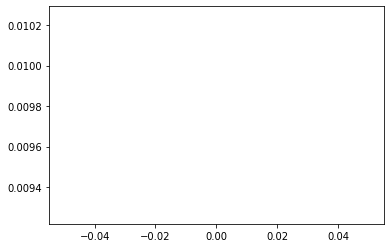

  0%|          | 1/300 [01:50<9:10:26, 110.46s/it]


KeyboardInterrupt: ignored

In [13]:
model_10 = utils_model.train(train_loader_10, test_loader_10, model_10,
                             criterion, optimizer_10, scheduler_10,
                             path_to_model_save = './scheduler/cifar10',
                             n_epochs=300, embed_step = 10, device=device)



# Save result

In [ ]:
!zip -r /content/scheduler.zip /content/scheduler

In [ ]:
from google.colab import files
files.download("/content/scheduler.zip")

# Scheduler based embedding on CIFAR-100 

  0%|          | 0/300 [00:00<?, ?it/s]

[Epoch 1] train loss: 2.943; train acc: 0.27; test loss: 5.289; test acc: 0.21


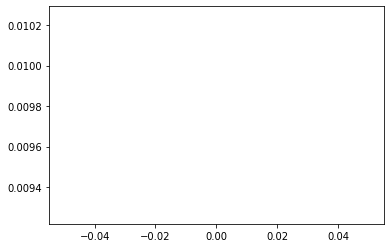

  0%|          | 1/300 [01:02<5:13:44, 62.96s/it]


KeyboardInterrupt: ignored

In [14]:
model_100 = utils_model.train(train_loader_100, test_loader_100, model_100,
                              criterion, optimizer_100, scheduler_100,
                              path_to_model_save = './scheduler/cifar100',
                              n_epochs=300, embed_step = 10, device=device)




# Save results

In [ ]:
!zip -r /content/scheduler.zip /content/scheduler

In [ ]:
from google.colab import files
files.download("/content/scheduler.zip")